In [1]:
import pandas as pd
import numpy as np
import _pickle as pkl
from sklearn.model_selection import train_test_split
import re
import os
from bs4 import BeautifulSoup
from collections import Counter
from string import punctuation
from scipy.sparse import hstack
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk import pos_tag, word_tokenize

df = pd.read_csv('./datasets/train.csv')
print(df.head(5))

   Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...


### Read and Split Data

In [2]:
print("Label:\n", df.loc[0, 'Popularity'])
print("Content:\n",df.loc[0,'Page content'])

Label:
 -1
Content:
 <html><head><div class="article-info"> <span class="byline basic">Clara Moskowitz</span> for <a href="/publishers/space-com/">Space.com</a> <time datetime="Wed, 19 Jun 2013 15:04:30 +0000">2013-06-19 15:04:30 UTC</time> </div></head><body><h1 class="title">NASA's Grand Challenge: Stop Asteroids From Destroying Earth</h1><figure class="article-image"><img class="microcontent" data-fragment="lead-image" data-image="http://i.amz.mshcdn.com/I7b9cUsPSztew7r1WT6_iBLjflo=/950x534/2013%2F06%2F19%2Ffe%2FDactyl.44419.jpg" data-micro="1" data-url="http://mashable.com/2013/06/19/nasa-grand-challenge-asteroid/" src="http://i.amz.mshcdn.com/I7b9cUsPSztew7r1WT6_iBLjflo=/950x534/2013%2F06%2F19%2Ffe%2FDactyl.44419.jpg"/></figure><article data-channel="world"><section class="article-content"> <p>There may be killer asteroids headed for Earth, and NASA has decided to do something about it. The space agency announced a new "Grand Challenge" on June 18 to find all dangerous space rocks

In [3]:
X = df.loc[:, 'Page content'].to_numpy()
y = df.loc[:,'Popularity'].to_numpy()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

print(X_train.shape)
print(y_train.shape)
print("Label:\n", y_train[0])
print("Content:\n", X_train[0])

(22114,)
(22114,)
Label:
 -1
Content:
 <html><head><div class="article-info"><span class="byline "><a href="/author/emily-banks/"><img alt="Default-m" class="author_image" src="http://i.amz.mshcdn.com/raEPzavg65Jzvjy-L4U699QBlmQ=/90x90/default-m.jpg"/></a><span class="author_name">By <a href="/author/emily-banks/">Emily Banks</a></span><time datetime="Fri, 01 Mar 2013 14:53:58 +0000">2013-03-01 14:53:58 UTC</time></span></div></head><body><h1 class="title">Mason Out at Groupon and More News You Need to Know</h1><figure class="article-image"></figure><article data-channel="business"><section class="article-content"> <div class="shift-to-hero"><div class="content-mash-video" data-autoplay="" data-embedurl="http://mashable.com/videos/embed?video=uGc7uydu&amp;player=offsite" data-labels='["Advertising", "Andrew Mason", "CEO", "Facebook", "Groupon", "adidas", "atlas", "college basketball", "first to know", "microsoft", "newsy", "twitter"]' data-playlist="http://content.jwplatform.com/manife

### Organize Positive / Negative Words

In [4]:
import os

POSITIVE_WORDS = os.path.join(os.getcwd(), 'datasets', 'positive-words.txt')
NEGATIVE_WORDS = os.path.join(os.getcwd(), 'datasets', 'negative-words.txt')
pos_words = []
neg_words = []


for line in open(POSITIVE_WORDS, 'r').readlines()[35:]:
    word = line.rstrip()
    pos_words.append(word)

for line in open(NEGATIVE_WORDS, 'r').readlines()[35:]:
    word = line.rstrip()
    neg_words.append(word)
    
print(len(pos_words))
print(len(neg_words))

2006
4783


### Stemmer

In [5]:
stop = stopwords.words('english')

def tokenizer_stem_neg(text):
    stemmer = LancasterStemmer()
    return [stemmer.stem(w) for w in re.split(r'\s+', text.strip()) \
            if w in neg_words and re.match('[a-zA-Z]+', w)]

def tokenizer_stem_pos(text):
    stemmer = LancasterStemmer()
    return [stemmer.stem(w) for w in re.split(r'\s+', text.strip()) \
            if w in pos_words and re.match('[a-zA-Z]+', w)]

def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split(r'\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

### Feature Engineering

### Content feature

In [26]:
import re
from bs4 import BeautifulSoup

def content_first_last(text):
    soup = BeautifulSoup(text, 'html.parser')
    feature_str = ""
    
    # Title
    feature_str += soup.find("h1", {"class": "title"}).text + " "

    # Channel
    feature_str += soup.find("article").get("data-channel") + " "

    # Author
    author_re = r'(?:By\s|by\s)?([a-zA-Z]+(\s[A-Z][a-z]+)*)'
    if soup.head.find("span") == None:
        feature_str += " "
    else:
        author = re.search(author_re, soup.head.find("span").text).group(1)
        feature_str += author.split(" ")[-1] + " "

    # Related Topics
    feature_str += soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").replace(",", "")
    
    # Content first and last sentence
    section = soup.find("section", {"class": "article-content"})
    para_first_last_list = section.find_all('p')
    for para in para_first_last_list:
        para_text = para.get_text()
        if(para_text == None): continue
        sentences = para_text.split('.')
        sentences = [sentence.strip() for sentence in para_text.split('.') if sentence.strip()]
        if len(sentences) >= 2:
            first_sentence = sentences[0].strip() 
            last_sentence = sentences[-1].strip()  
            feature_str += first_sentence + last_sentence
        elif len(sentences) == 1:
            feature_str += sentences[0]
        else: 
            feature_str += ''
        
    # remove numbers
    feature_str = re.sub(r'\d+', '', feature_str)
    
    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = r'(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, feature_str)
    feature_str = re.sub(r, '', feature_str)

    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    feature_str = re.sub(r'[\W]+', ' ', feature_str.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    
    return feature_str


print(content_first_last(X[70]))

senior employees are a firm s biggest cybersecurity weakness business business small business startups work play the biggest threat to your company s cybersecurity isn t malware phishing scams or even hackers it s youand while the surveys each pointed to slightly different culprits the verdict was clear employees are the weakest link in the security chainthe largest of the three studies a stroz friedberg online survey of more than information workers found that senior management may be the biggest threat to an organization s digital well beingonly percent of rank and file employees were found to have done the samethe stroz friedberg study also found that in senior managers admitted to uploading work files to personal email and cloud based accounts a faux pas that could lead to intellectual property theft and attacks on corporate networkssee also which employees are the biggest security risk in a second study by osterman research security professionals were asked about the biggest cyber

### All Vector Features (Word + Stats)

In [9]:
def feature_selection(data):
    feature_str = ""
    soup = BeautifulSoup(data, 'html.parser')

    # Title
    feature_str += soup.find("h1", {"class": "title"}).text + " "

    # Channel
    feature_str += soup.find("article").get("data-channel") + " "

    # Author
    author_re = r'(?:By\s|by\s)?([a-zA-Z]+(\s[A-Z][a-z]+)*)'
    if soup.head.find("span") == None:
        feature_str += " "
    else:
        author = re.search(author_re, soup.head.find("span").text).group(1)
        feature_str += author.split(" ")[-1] + " "

    # Related Topics
    feature_str += soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").replace(",", "")

    # Time
    if soup.time.text == None or soup.time.text == "":
        feature_str += "0"
    else:
        hour = int(re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5].split(":")[0])
        minute = int(re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5].split(":")[1])
        if hour * 60 + minute < 540:
            feature_str += "morning "
        elif hour * 60 + minute < 720:
            feature_str += "noon "
        elif hour * 60 + minute < 1020:
            feature_str += "afternoon "
        else:
            feature_str += "night "

    # Weekend
    if soup.time.text == None or soup.time.text == "":
        feature_str += "weekday "
    else:
        feature_str += "weekend " if soup.time.get("datetime")[:3] in ["Sat", "Sun"] else "weekday "

    # Word Count
    text_p = (''.join(s.findAll(string=True))for s in soup.findAll('p'))
    c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
    text_div = (''.join(s.findAll(string=True))for s in soup.findAll('div'))
    c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))
    total = c_div + c_p
    if len(list(total.elements())) < 300:
        feature_str += 'wordshort '
    elif len(list(total.elements())) < 600:
        feature_str += 'wordmedium '
    else:
        feature_str += 'wordlong '


    section = soup.find("section", {"class": "article-content"})

    # Video + Image count
    img_count = len(section.find_all("img")) + len(section.find_all("picture")) + len(section.find_all("figure"))
    video_count = len(section.find_all("video")) + len(section.find_all("iframe"))
    media_count = img_count + video_count
    if media_count < 3:
        feature_str += "nomedia "
    elif media_count < 7:
        feature_str += "fewmedia "
    else:
        feature_str += "manymedia "

    # Appealing count
    link_count = len(section.find_all("a"))
    strong_count = len(section.find_all("strong"))
    appealing_count = link_count + strong_count
    if appealing_count < 5:
        feature_str += "appealshort "
    elif appealing_count < 10:
        feature_str += "appealmedium "
    else:
        feature_str += "appeallong "

    paragraph = section.find_all("p")
    
    # Statistics count
    stat_count = 0
    for tag in paragraph:
        number = r'\d+'
        matches = re.findall(number, tag.text)
        stat_count += len(matches)
    if stat_count < 5:
        feature_str += "fewstats "
    elif stat_count < 10:
        feature_str += "somestats "
    elif stat_count < 20:
        feature_str += "manystats "
    else:
        feature_str += "lotstats "

    # POS & NEG count
    pos_count = 0
    for tag in paragraph:
        pos_count += len(tokenizer_stem_pos(tag.text))
        for word in tokenizer_stem_pos(tag.text):
            feature_str += word + " "


    neg_count = 0
    for tag in paragraph:
        neg_count += len(tokenizer_stem_neg(tag.text))
        for word in tokenizer_stem_neg(tag.text):
            feature_str += word + " "
    

    feature_str = re.sub(r'[,-.:\']+', '', feature_str.lower())
    return feature_str

### Feature Info Wrod Selection

In [10]:
def feature_selection_info_word(data):
    feature_str = ""
    soup = BeautifulSoup(data, 'html.parser')

    # Title
    feature_str += soup.find("h1", {"class": "title"}).text + " "

    # Channel
    feature_str += soup.find("article").get("data-channel") + " "

    # Author
    author_re = r'(?:By\s|by\s)?([a-zA-Z]+(\s[A-Z][a-z]+)*)'
    if soup.head.find("span") == None:
        feature_str += " "
    else:
        author = re.search(author_re, soup.head.find("span").text).group(1)
        feature_str += author.split(" ")[-1] + " "

    
    section = soup.find("section", {"class": "article-content"})
    paragraph = section.find_all("p")

    # Postive word
    pos_count = 0
    for tag in paragraph:
        pos_count += len(tokenizer_stem_pos(tag.text))
        for word in tokenizer_stem_pos(tag.text):
            feature_str += word + " "

    # Negative word
    neg_count = 0
    for tag in paragraph:
        neg_count += len(tokenizer_stem_neg(tag.text))
        for word in tokenizer_stem_neg(tag.text):
            feature_str += word + " "

    # Related Topics
    feature_str += soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").replace(",", "")

    feature_str = re.sub(r'[.:\']', '', feature_str.lower())
    return feature_str

print(feature_selection_info_word(X[0]))

nasas grand challenge stop asteroids from destroying earth world moskowitz improv pref confid win support benefit valu integr win support import accompl innov tim kil dang threats asteroid asteroids challenge earth space us world 


### Feature Info stats selection

In [95]:
from collections import Counter
from string import punctuation
import re
import math
from bs4 import BeautifulSoup

author_score = dict()
author_num = dict()
channel_score = dict()
channel_num = dict()
topic_score = dict()
topic_num = dict()
avg_author = 0
avg_channel = 0
avg_topic = 0

def get_info_score(X_train, y_train):
    global author_score
    global author_num 
    global channel_score 
    global channel_num 
    global topic_score 
    global topic_num 
    global avg_author 
    global avg_channel 
    global avg_topic 

    for html, y in zip(X_train, y_train):
        soup = BeautifulSoup(html, 'html.parser')

        # Author
        author_re = r'(?:By\s|by\s)?([a-zA-Z]+(\s[A-Z][a-z]+)*)'
        if soup.head.find("span") == None:
            continue
        else:
            author = re.search(author_re, soup.head.find("span").text).group(1)
            if author in author_score:
                author_score[author] += 1 if int(y) == 1 else 0
                author_num[author] += 1
            else : 
                author_score[author] = 0
                author_score[author] += 1 if int(y) == 1 else 0
                author_num[author] = 1

        # Channel
        channel = soup.find("article").get("data-channel")
        if channel in channel_score:
            channel_score[channel] += 1 if int(y)==1 else  0
            channel_num[channel] += 1
        else : 
            channel_score[channel] = 0
            channel_score[channel] += 1 if int(y)==1 else  0
            channel_num[channel] = 1
        
        # Topics
        topics = soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").split(",")
        for topic in topics:
            if topic in topic_score:
                topic_score[topic] += 1 if int(y)==1 else  0
                topic_num[topic] += 1
            else : 
                topic_score[topic] = 0
                topic_score[topic] += 1 if int(y)==1 else  0
                topic_num[topic] = 1

    total_channel = 0
    total_topic = 0
    total_author = 0
    for html in X_train:
        for c, s in channel_score.items():
            avg_channel += s
            total_channel += channel_num[c]
        avg_channel = avg_channel / total_channel

        for c, s in topic_score.items():
            avg_topic += s
            total_topic += topic_num[c]
        avg_topic = avg_topic / total_topic

        for c, s in author_score.items():
            avg_author += s
            total_author += author_num[c]
        avg_author = avg_author / total_author
        

get_info_score(X_train, y_train) # init author_score

In [166]:
from collections import Counter
from string import punctuation
import re
import math
from bs4 import BeautifulSoup

def feature_selection_info_num(data):
    X = []
    for html in data:
        soup = BeautifulSoup(html, 'html.parser')
        feature_list = []
        
        # # Author score
        # author_re = r'(?:By\s|by\s)?([a-zA-Z]+(\s[A-Z][a-z]+)*)'
        # if soup.head.find("span") == None:
        #     feature_list.append(avg_author)
        # else:
        #     author = re.search(author_re, soup.head.find("span").text).group(1)
        #     if(author in author_score):
        #         feature_list.append(author_score[author] / author_num[author])
        #     else:
        #         feature_list.append(avg_author)  

        # # Channel score
        # channel = soup.find("article").get("data-channel")
        # if channel in channel_score:
        #     feature_list.append(channel_score[channel] / channel_num[channel])
        # else:
        #     feature_list.append(avg_channel)

        # # Topic score
        # topics = soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").split(",")
        # total_score = 0
        # order = 0 
        # order_denominator = 0
        # for i in range(len(topics)):
        #     order_denominator += math.exp(-0.5 * i)
        # for topic in topics:
        #     order_coef = math.exp(-0.5*order)/order_denominator
        #     if topic in topic_score:
        #         total_score += (topic_score[topic] / topic_num[topic]) * order_coef
        #     else:
        #         total_score += avg_topic * order_coef
        #     order+=1
        # feature_list.append(total_score)
              
        # word count of title
        feature_list.append(len(soup.find("h1", {"class": "title"}).text))
        
        # average word length and unique word rate
        words = re.findall(r'\w+', soup.get_text().lower())
        if words:
            total_words = len(words)
            unique_words = set(words)
            unique_word_count = len(unique_words)
            total_length = sum(len(word) for word in words)
            unique_rate = unique_word_count / total_words
            average_length = total_length / len(words)
            feature_list.append(unique_rate)
            feature_list.append(average_length)
        
        # Time
        if soup.time.text == None or soup.time.text == "":
            feature_list.append(0)
            feature_list.append(0)
        else:
            month = int(re.search(r'(\d+-\d+-\d+)', soup.time.text).group(1).split("-")[1])
            feature_list.append(month)
            hour = int(re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5].split(":")[0])
            minute = int(re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5].split(":")[1])
            feature_list.append(hour * 60 + minute)

        # Weekend
        if soup.time.text == None or soup.time.text == "":
            feature_list.append(0)
        else:
            feature_list.append(1 if soup.time.get("datetime")[:3] in ["Sat", "Sun"] else 0)

        # Word Count
        text_p = (''.join(s.findAll(string=True))for s in soup.findAll('p'))
        c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
        text_div = (''.join(s.findAll(string=True))for s in soup.findAll('div'))
        c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))
        total = c_div + c_p
        feature_list.append(len(list(total.elements())))


        section = soup.find("section", {"class": "article-content"})

        # Video + Image count
        img_count = len(section.find_all("img")) + len(section.find_all("picture")) + len(section.find_all("figure"))
        video_count = len(section.find_all("video")) + len(section.find_all("iframe"))
        media_count = img_count + video_count
        feature_list.append(media_count)

        # Appealing count
        link_count = len(section.find_all("a"))
        strong_count = len(section.find_all("strong"))
        appealing_count = link_count + strong_count
        feature_list.append(appealing_count)
        
        # See also count
        feature_list.append(len(soup.find_all("div", {"class": "see-also"})))

        # POS & NEG count
        paragraph = section.find_all("p")
        pos_count = 0
        for tag in paragraph:
            pos_count += len(tokenizer_stem_pos(tag.text))
        feature_list.append(pos_count)

        neg_count = 0
        for tag in paragraph:
            neg_count += len(tokenizer_stem_neg(tag.text))
        feature_list.append(neg_count)

        # Question & Exclamation count
        # q_count = 0
        # ex_count = 0
        # for tag in paragraph:
        #     if tag.text.find("?") != -1:
        #         q_count += tag.text.find("?")
        #     if tag.text.find("!") != -1:
        #         ex_count += tag.text.find("!")
        
        # feature_list.append(q_count)
        # feature_list.append(ex_count)

        X.append(feature_list)
        
    return np.array(X)

print(feature_selection_info_num(X[:10]))

[[6.00000000e+01 4.89731438e-01 4.81042654e+00 6.00000000e+00
  9.04000000e+02 0.00000000e+00 5.43000000e+02 0.00000000e+00
  1.80000000e+01 0.00000000e+00 1.40000000e+01 3.00000000e+00]
 [7.40000000e+01 4.74719101e-01 4.65449438e+00 3.00000000e+00
  1.06000000e+03 0.00000000e+00 3.21000000e+02 0.00000000e+00
  9.00000000e+00 1.00000000e+00 5.00000000e+00 3.00000000e+00]
 [6.80000000e+01 4.98765432e-01 4.40987654e+00 5.00000000e+00
  1.15500000e+03 0.00000000e+00 2.55800000e+03 5.00000000e+01
  4.00000000e+00 1.00000000e+00 3.30000000e+01 2.10000000e+01]
 [4.30000000e+01 7.26351351e-01 4.65540541e+00 1.00000000e+01
  1.46000000e+02 0.00000000e+00 4.86000000e+02 4.10000000e+01
  8.00000000e+00 1.00000000e+00 2.00000000e+00 5.00000000e+00]
 [6.10000000e+01 4.80314961e-01 4.56167979e+00 4.00000000e+00
  2.11000000e+02 0.00000000e+00 1.59400000e+03 1.01000000e+02
  1.00000000e+01 1.00000000e+00 8.00000000e+00 1.00000000e+00]
 [5.00000000e+01 4.80791618e-01 4.77415600e+00 1.10000000e+01
  1

### Feature Selection(Johnson Version)

In [213]:
import math
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

author_score =dict()
author_num = dict()
channel_score = dict()
channel_num = dict()
topic_score = dict()
topic_num = dict()
avg_author = 0
avg_channel = 0
avg_topic = 0

def feature_selection_part2(data, istraining):
    X = []
    idx=0
    global author_score
    global author_num 
    global channel_score 
    global channel_num 
    global topic_score 
    global topic_num 
    global avg_author 
    global avg_channel 
    global avg_topic 
    
    if(istraining):
        for html in data:
            soup = BeautifulSoup(html, 'html.parser')
            channel = soup.find("article").get("data-channel")
            if channel in channel_score:
                channel_score[channel] += 1 if int(y[idx])==1 else  0
                channel_num[channel] += 1
            else : 
                channel_score[channel] = 0
                channel_score[channel] += 1 if int(y[idx])==1 else  0
                channel_num[channel] = 1
            
            topics = soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").split(",")
            for topic in topics:
                if topic in topic_score:
                    topic_score[topic] += 1 if int(y[idx])==1 else  0
                    topic_num[topic] += 1
                else : 
                    topic_score[topic] = 0
                    topic_score[topic] += 1 if int(y[idx])==1 else  0
                    topic_num[topic] = 1


            # Author
            author_re = r'(?:By\s|by\s)?([a-zA-Z]+(\s[A-Z][a-z]+)*)'
            if soup.head.find("span") == None:
                continue
            else:
                author = re.search(author_re, soup.head.find("span").text).group(1)
                if author in author_score:
                    author_score[author] += 1 if int(y[idx])==1 else  0
                    author_num[author] += 1
                else : 
                    author_score[author] = 0
                    author_num[author] = 1
                    author_score[author] += 1 if int(y[idx])==1 else  0
            idx+=1
        total_channel = 0
        total_topic = 0
        total_author = 0
        for c,s in channel_score.items():
            avg_channel+=s
            total_channel+=channel_num[c]
        avg_channel = avg_channel/total_channel

        for c,s in topic_score.items():
            avg_topic+=s
            total_topic+=topic_num[c]
        avg_topic = avg_topic/total_topic

        for c,s in author_score.items():
            avg_author+=s
            total_author+=author_num[c]
        avg_author = avg_author/total_author

    for html in data:
        soup = BeautifulSoup(html, 'html.parser')
        feature_list = []
        # Author score
        author_re = r'(?:By\s|by\s)?([a-zA-Z]+(\s[A-Z][a-z]+)*)'
        if soup.head.find("span") == None:
            feature_list.append(0.5)
        else:
            author = re.search(author_re, soup.head.find("span").text).group(1)
            if author in author_score:
                feature_list.append(author_score[author]/author_num[author])
            else:
                feature_list.append(0.5)
        # Channel score
        channel = soup.find("article").get("data-channel")
        if channel in channel_score:
            feature_list.append(channel_score[channel]/channel_num[channel])
        else:
            feature_list.append(0.5)
            
        # Topic score
        topics = soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").split(",")
        total_score = 0
        order = 0 
        order_denominator = 0
        for i in range(len(topics)):
            order_denominator += math.exp(-0.5*i)

        for topic in topics:
            order_coef = math.exp(-0.5*order)/order_denominator
            if topic in topic_score:
                total_score+=(topic_score[topic]/topic_num[topic])*order_coef
            else:
                total_score+=0.5*order_coef
            order+=1
        
        feature_list.append(total_score) 

        # word count of title
        title = soup.find("h1", {"class": "title"}).text
        feature_list.append(len(title))
        # average word length and unique word rate
        words = re.findall(r'\w+', soup.get_text().lower())
        if words:
            total_words = len(words)
            unique_words = set(words)
            unique_word_count = len(unique_words)
            total_length = sum(len(word) for word in words)
            unique_rate = unique_word_count / total_words
            average_length = total_length / len(words)
            feature_list.append(unique_rate)
            feature_list.append(average_length)
        
        # Time
        if soup.time.text == None or soup.time.text == "":
            feature_list.append(0)
            feature_list.append(0)
        else:
            month = int(re.search(r'(\d+-\d+-\d+)', soup.time.text).group(1).split("-")[1])
            feature_list.append(month)
            hour = int(re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5].split(":")[0])
            minute = int(re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5].split(":")[1])
            time = (hour * 60 + minute-300)%1440
            time_demarcation = 0
            if(300<=time and time<=720):
                time_demarcation = 1
            elif(720<time and time<=960):
                time_demarcation = 2
            elif(960<time and time <=1440):
                time_demarcation = 3
            else:
                time_demarcation = 4
            feature_list.append(time_demarcation)

        # Weekday
        if soup.time.text == None or soup.time.text == "":
            feature_list.append(0)
        else:
            weekday = soup.time.get("datetime")[:3]
            if(weekday == "Mon"):
                feature_list.append(1)
            elif(weekday == "Tue"):
                feature_list.append(2)
            elif(weekday == "Wed"):
                feature_list.append(3)
            elif(weekday == "Thu"):
                feature_list.append(4)
            elif(weekday == "Fri"):
                feature_list.append(5)
            elif(weekday=="Sat"):
                feature_list.append(6)
            elif(weekday=="Sun"):
                feature_list.append(7)
            else: feature_list.append(0)

        # Word Count
        text_p = (''.join(s.findAll(string=True))for s in soup.findAll('p'))
        c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
        text_div = (''.join(s.findAll(string=True))for s in soup.findAll('div'))
        c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))
        total = c_div + c_p
        #feature_list.append(len(list(total.elements())))

        section = soup.find("section", {"class": "article-content"})

        # Video + Image count
        img_count = len(section.find_all("img")) + len(section.find_all("picture")) + len(section.find_all("figure"))
        video_count = len(section.find_all("video")) + len(section.find_all("iframe"))
        media_count = img_count + video_count
        feature_list.append(media_count)

        # Appealing count
        link_count = len(section.find_all("a"))
        strong_count = len(section.find_all("strong"))
        appealing_count = link_count + strong_count
        feature_list.append(appealing_count)

        # POS & NEG count
        paragraph = section.find_all("p")
        pos_count = 0
        neg_count = 0
        q_count = 0
        ex_count = 0
        para_count = 0
        content=""
        for tag in paragraph:
            content+=tag.text
            para_count += 1
            pos_count += len(tokenizer_stem_pos(tag.text))
            neg_count += len(tokenizer_stem_neg(tag.text))
            if tag.text.find("?") != -1:
                q_count += tag.text.find("?")
            if tag.text.find("!") != -1:
                ex_count += tag.text.find("!")
        word_cnt = len(list(total.elements()))
        feature_list.append(pos_count/word_cnt)    
        feature_list.append(neg_count/word_cnt)
        #feature_list.append(q_count)
        feature_list.append(ex_count/word_cnt)
        feature_list.append(word_cnt/para_count)
        analyzer = SentimentIntensityAnalyzer()
        # Title sentiment analysis
        sentiment_title = analyzer.polarity_scores(title)
        feature_list.append(sentiment_title['compound'])
        # Content sentiment analysis
        sentiment_content = analyzer.polarity_scores(content)
        feature_list.append(sentiment_content['compound'])
        X.append(feature_list)
    return np.array(X)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hui/nltk_data...


### Feature Importance

In [ ]:
# from sklearn.linear_model import Ridge
# lasso = Ridge()
# lasso.fit(x_train, Y_train)
# #'author_score', 'channel_score', 'topic_score', 
# indexes = ['title word count', 'unique_rate',
#            'average_word_length', 'month', 'time_demarcation', 'weekday', 'media_count'
#            , 'appealing_count', 'pos_rate', 'neg_rate', 'q_rate','ex_rate', 'avg_para_word_cnt',
#             'title_sentiment', 'content_sentiment']
# coef = pd.Series(lasso.coef_,index=indexes)
# print(coef.abs().sort_values(ascending = False))

### TF-IDF

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2),
                        preprocessor=content_first_last,
                        tokenizer=tokenizer_stem_nostop,
                        max_features=1000)

tfidf.fit(X_train)

top = 100
# get idf score of vocabularies
idf = tfidf.idf_
# print('[vocabularies with smallest idf scores]')
# sorted_idx = idf.argsort()

# for i in range(top):
#     # When sklearn version <= 0.24.x, should use get_feature_names()
#     # When sklearn version >= 1.0.x, should use get_feature_names_out()
#     print('%s: %.2f' %(tfidf.get_feature_names_out()[sorted_idx[-(i+1)]], idf[sorted_idx[-(i+1)]]))


doc_tfidf = tfidf.transform(X_train).toarray()
tfidf_sum = np.sum(doc_tfidf, axis=0)
print("\n[vocabularies with highest tf-idf scores]")
for tok, v in zip(tfidf.inverse_transform(np.ones((1, tfidf_sum.shape[0])))[0][tfidf_sum.argsort()[::-1]][:top], \
                        np.sort(tfidf_sum)[::-1][:top]):
    print('{}: {}'.format(tok, v))

/Users/hui/anaconda3/envs/DeepLearning/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



[vocabularies with highest tf-idf scores]
video: 936.9509498571376
us: 863.6564949281948
new: 793.5961139492256
ap: 722.075907306366
also: 683.1967662881051
gam: 608.3270210004524
world: 604.6719478389231
on: 574.6213342702274
lik: 538.3092741968458
watercool: 533.355509474707
tim: 523.1407742214898
com: 515.3713785797258
said: 510.8396831010344
year: 508.6617214704774
googl: 505.3688963963648
company: 498.0206617171502
busy: 495.28238768252584
ev: 480.6867698755683
tech: 472.73977061151464
mak: 466.9482644572476
facebook: 459.2232023496021
soc: 459.023539250993
med: 457.8890423810361
im: 448.6881561834264
get: 446.06335536554894
twit: 441.2058666287875
appl: 440.3454693942127
courtesy: 439.9559908908447
first: 435.2581255764418
show: 433.00753433989274
entertain: 430.41979156177916
work: 427.5007041769656
peopl: 403.57610577768395
off: 403.5073179626609
ad: 403.3332990390443
mus: 398.3600361424845
act: 395.7544526772645
say: 393.3986321180629
tak: 389.12095940907756
look: 382.6190228

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_info = TfidfVectorizer(ngram_range=(1,2),
                        preprocessor=feature_selection,
                        tokenizer=tokenizer_stem_nostop)

tfidf_info.fit(X_train)

top = 10
# get idf score of vocabularies
idf = tfidf_info.idf_
# print('[vocabularies with smallest idf scores]')
# sorted_idx = idf.argsort()

# for i in range(top):
#     # When sklearn version <= 0.24.x, should use get_feature_names()
#     # When sklearn version >= 1.0.x, should use get_feature_names_out()
#     print('%s: %.2f' %(tfidf.get_feature_names_out()[sorted_idx[-(i+1)]], idf[sorted_idx[-(i+1)]]))


doc_tfidf = tfidf_info.transform(X_train).toarray()
tfidf_sum = np.sum(doc_tfidf, axis=0)
print("\n[vocabularies with highest tf-idf scores]")
for tok, v in zip(tfidf_info.inverse_transform(np.ones((1, tfidf_sum.shape[0])))[0][tfidf_sum.argsort()[::-1]][:top], \
                        np.sort(tfidf_sum)[::-1][:top]):
    print('{}: {}'.format(tok, v))

/Users/hui/anaconda3/envs/DeepLearning/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



[vocabularies with highest tf-idf scores]
lik: 524.2425059933894
video: 411.9180877401005
world: 382.6039457315728
weekday: 372.6749264003716
tech: 357.6536186652545
work: 356.56591377847866
watercool: 346.1691680047321
nomed: 344.6883622348576
busy: 324.5313985302504
entertain: 317.95987013846667


### Hashing Vectorizer

In [17]:
import numpy as np
import scipy as sp
from sklearn.feature_extraction.text import HashingVectorizer

# hash words to 2048 buckets
hashvec = HashingVectorizer(n_features=2**20,
                            preprocessor=feature_selection,
                            tokenizer=tokenizer_stem_nostop)

### Random mini batches

In [18]:
import math

def random_mini_batches(X, Y, mini_batch_size = 64):
    m = X.shape[0]  # number of training examples
    mini_batches = []
        
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation]
    shuffled_Y = Y[permutation]
    
    # Cases with a complete mini batch size only i.e each of 64 examples.
    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # For handling the end case (last mini-batch < mini_batch_size i.e less than 64)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


### MultiVec + MultiClassifier

In [167]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

y_train_label = LabelEncoder().fit_transform(y_train)
y_valid_label = LabelEncoder().fit_transform(y_valid)
hashvec_word = HashingVectorizer(n_features=2**20, preprocessor=feature_selection, tokenizer=tokenizer_stem_nostop)
hashvec_content =  HashingVectorizer(n_features=2**20, preprocessor=content_first_last, tokenizer=tokenizer_stem_nostop)
x_train_info_word = hashvec_word.transform(X_train)
x_valid_info_word = hashvec_word.transform(X_valid)
x_train_info_num = feature_selection_info_num(X_train)
x_valid_info_num = feature_selection_info_num(X_valid)
x_train_content_hash = hashvec_content.transform(X_train)
x_valid_content_hash = hashvec_content.transform(X_valid)
# x_train_content_tfidf = tfidf.transform(X_train)
# x_valid_content_tfidf = tfidf.transform(X_valid)

### Info word model

In [198]:
# Info-word model
# info_word_model  = XGBClassifier(
#     n_estimators=600, 
#     max_depth=7, 
#     early_stopping_rounds=20,
#     objective='binary:logistic', 
#     reg_lambda=0.1, 
#     min_child_weight=1, 
#     n_jobs=-1)
info_word_model = SGDClassifier(loss='log_loss', alpha=0.0003, max_iter=1000, tol=1e-3, n_jobs=-1)
# info_word_model = RandomForestClassifier(n_estimators=600, max_depth=5, min_samples_leaf=4, n_jobs=-1)

print('Begin Info word Training...')
eval_set = [(x_valid_info_word, y_valid_label)]
# info_word_model.fit(x_train_info_word, y_train_label, eval_set=eval_set)
info_word_model.fit(x_train_info_word, y_train_label)

print('Begin Evaluation...')
y_pred_info_word_train = info_word_model.predict_proba(x_train_info_word)[:,1]
y_pred_info_word_valid = info_word_model.predict_proba(x_valid_info_word)[:,1]
print("Info word train:", roc_auc_score(y_train_label, y_pred_info_word_train))
print("Info word valid:", roc_auc_score(y_valid_label, y_pred_info_word_valid))

Begin Info word Training...
Begin Evaluation...
Info word train: 0.6448073115920003
Info word valid: 0.5746142716858981


### Info num model

In [286]:
# Info-num model
# info_num_model = GradientBoostingClassifier(n_estimators=200, learning_rate=1.0, max_depth=1, random_state=0)
# info_num_model = RandomForestClassifier(n_estimators=500, max_depth=12, min_samples_leaf=4, n_jobs=-1)
# info_num_model = XGBClassifier(
#     n_estimators=500, 
#     max_depth=9, 
#     early_stopping_rounds=20,
#     objective='binary:logistic', 
#     reg_lambda=0.1, 
#     min_child_weight=1, 
#     n_jobs=-1)
info_num_model = LGBMClassifier(
  n_estimators=600, 
  max_depth=7, 
  num_leaves=100,
  min_child_samples=8,
  reg_lambda=1.2, 
  early_stopping_rounds=20,
  n_jobs=-1,
  verbosity=-1)
# info_num_model = SGDClassifier(loss='log_loss', max_iter=300, tol=1e-3, n_jobs=-1)

print("Begin Info num Training...")
eval_set = [(x_valid_info_num, y_valid_label)]
info_num_model.fit(x_train_info_num, y_train_label, eval_set=eval_set)
# info_num_model.fit(x_train_info_num, y_train_label)

y_pred_info_num_train = info_num_model.predict_proba(x_train_info_num)[:,1]
y_pred_info_num_valid = info_num_model.predict_proba(x_valid_info_num)[:,1]
print("Info num train:", roc_auc_score(y_train_label, y_pred_info_num_train))
print("Info num valid:", roc_auc_score(y_valid_label, y_pred_info_num_valid))

Begin Info num Training...
Info num train: 0.6861954244659765
Info num valid: 0.5832932241841027


In [214]:
x_train_info_num_2 = feature_selection_part2(X_train, True)
x_valid_info_num_2 = feature_selection_part2(X_valid, False)

In [297]:
# Info_2
# info_num_model_2 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01, max_depth=3, random_state=0)
# info_num_model_2 = RandomForestClassifier(n_estimators=500, max_depth=5, min_samples_leaf=16, n_jobs=-1)
info_num_model_2 = LGBMClassifier(
  n_estimators=1000, 
  max_depth=7, 
  num_leaves=30,
  min_child_samples=35,
  reg_lambda=2, 
  early_stopping_rounds=20,
  n_jobs=-1,
  verbosity=-1)

print("Begin Info num Training...")
eval_set = [(x_valid_info_num_2, y_valid_label)]
info_num_model_2.fit(x_train_info_num_2, y_train_label, eval_set=eval_set)
# info_num_model_2.fit(x_train_info_num_2, y_train_label)

y_pred_info_num_train = info_num_model_2.predict_proba(x_train_info_num_2)[:,1]
y_pred_info_num_valid = info_num_model_2.predict_proba(x_valid_info_num_2)[:,1]
print("Info num train:", roc_auc_score(y_train_label, y_pred_info_num_train))
print("Info num valid:", roc_auc_score(y_valid_label, y_pred_info_num_valid))

Begin Info num Training...
Info num train: 0.6586388720246907
Info num valid: 0.5898505793514697


### Content model

In [205]:
# Content model
# content_model = RandomForestClassifier(n_estimators=500, max_depth=7, min_samples_leaf=8, n_jobs=-1)
# content_model = XGBClassifier(
#     n_estimators=500,
#     max_depth=12, 
#     early_stopping_rounds=20, 
#     objective='binary:logistic', 
#     reg_lambda=0.1, 
#     # min_child_weight=3,
#     n_jobs=-1)
content_model = LGBMClassifier(
  n_estimators=600, 
  max_depth=5, 
  num_leaves=30,
  min_child_samples=64, 
  reg_lambda=2, 
  early_stopping_rounds=20,
  n_jobs=-1,
  verbosity=-1)

print('Begin Content Training...')
# eval_set = [(tfidf.transform(X_valid), LabelEncoder().fit_transform(y_valid))]
eval_set = [(x_valid_content_hash, y_valid_label)]
# x_train_content = tfidf.transform(X_train)

content_model.fit(x_train_content_hash, y_train_label, eval_set=eval_set)
# content_model.fit(x_train_content_hash, y_train_label)

y_pred_content_train = content_model.predict_proba(x_train_content_hash)[:,1]
# y_pred_content_valid = content_model.predict_proba(tfidf.transform(X_valid))[:,1]
y_pred_content_valid = content_model.predict_proba(x_valid_content_hash)[:,1]
print("Content train:", roc_auc_score(y_train_label, y_pred_content_train))
print("Content valid:", roc_auc_score(y_valid_label, y_pred_content_valid))

Begin Content Training...
Content train: 0.690066547423914
Content valid: 0.5637874186301175


### Voting model(all)

In [ ]:
from sklearn.ensemble import VotingClassifier
voter1 = XGBClassifier(n_estimators=500, learning_rate=0.01, max_depth=3)
voter2 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01, max_depth=3, random_state=0)
# voter3 = RandomForestClassifier(n_estimators=400, max_depth=8, max_features=0.5)
#model = XGBClassifier(n_estimators=300, learning_rate=0.0006, max_depth=4)
# model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01, max_depth=3, random_state=0)
# model = VotingClassifier(estimators=[('1', voter1), ('2', voter2)], voting='soft')
# model = RandomForestClassifier(n_estimators=400, max_depth=8, max_features=0.5)
model_v1 = XGBClassifier(n_estimators=400, learning_rate=0.0025, max_depth=6)
model_v3 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01, max_depth=3, random_state=0)

model = VotingClassifier(estimators=[('v1', model_v1), ('v3', model_v3)], voting='soft')
print('Begin Word Training...')
#x_train = feature_selection_part2(X_train, True)
y_train = LabelEncoder().fit_transform(y)
#y_valid = LabelEncoder().fit_transform(Y_valid)
voting = model.fit(x_train_info_num_2, y_train)
pkl.dump(model, open("output/backup_model.pickle", "wb"))

print('Begin Evaluation...')
y_pred_train = voting.predict_proba(x_train_info_num_2)[:,1]
#y_pred_valid = voting.predict_proba(x_valid)[:,1]

train_score = roc_auc_score(y_train, y_pred_train)
#valid_score = roc_auc_score(y_valid, y_pred_valid)
print(f'Stats train score: {train_score}')
#print(f'Stats valid score: {valid_score}')

### Ratio select

In [298]:
train_score = []
valid_score = []
coef_ = np.linspace(0,1,51)
max_score = 0
max_coef = [0, 0, 0]
for i in coef_:
    j_range = np.linspace(0, 1-i, 51)
    for j in j_range:
        k = 1 - i - j
        print(f'Proportion (Model 1): {i}, Proportion (Model 2): {j}, Proportion (Model 3): {k}')
        train_score = roc_auc_score(y_train_label, (y_pred_info_word_train*i) + (y_pred_info_num_train*j) + (y_pred_content_train*k))
        valid_score = roc_auc_score(y_valid_label, (y_pred_info_word_valid*i) + (y_pred_info_num_valid*j) + (y_pred_content_valid*k))
        if(train_score + valid_score * 2 > max_score ):
            max_score = train_score + valid_score * 2
            max_coef[0] = i
            max_coef[1] = j
            max_coef[2] = k
        print(f'Combine train score: {train_score}')
        print(f'Combine valid score: {valid_score}')

print(max_coef)
i, j, k = max_coef
train_score = roc_auc_score(y_train_label, (y_pred_info_word_train*i) + (y_pred_info_num_train*j) + (y_pred_content_train*k))
valid_score = roc_auc_score(y_valid_label, (y_pred_info_word_valid*i) + (y_pred_info_num_valid*j) + (y_pred_content_valid*k))
print(f'Combine train score: {train_score}')
print(f'Combine valid score: {valid_score}')

Proportion (Model 1): 0.0, Proportion (Model 2): 0.0, Proportion (Model 3): 1.0
Combine train score: 0.690066547423914
Combine valid score: 0.5637874186301175
Proportion (Model 1): 0.0, Proportion (Model 2): 0.02, Proportion (Model 3): 0.98
Combine train score: 0.6951492746605845
Combine valid score: 0.5672389646840577
Proportion (Model 1): 0.0, Proportion (Model 2): 0.04, Proportion (Model 3): 0.96
Combine train score: 0.6997443405016428
Combine valid score: 0.570552516943989
Proportion (Model 1): 0.0, Proportion (Model 2): 0.06, Proportion (Model 3): 0.94
Combine train score: 0.7038139273100263
Combine valid score: 0.5737057634688225
Proportion (Model 1): 0.0, Proportion (Model 2): 0.08, Proportion (Model 3): 0.92
Combine train score: 0.7074247610236224
Combine valid score: 0.576748562613719
Proportion (Model 1): 0.0, Proportion (Model 2): 0.1, Proportion (Model 3): 0.9
Combine train score: 0.710588377146651
Combine valid score: 0.5795917974761465
Proportion (Model 1): 0.0, Proportio

### Save model

In [ ]:
import pickle
info_word_file = "models/info_word_model.pkl"
info_num_file = "models/info_num_model.pkl"
content_file = "models/content_model.pkl"
with open(info_word_file, 'wb') as file:
    pickle.dump(info_word_model, file)
    
with open(info_num_file, 'wb') as file:
    pickle.dump(info_num_model, file)

with open(content_file, 'wb') as file:
    pickle.dump(content_model, file)

### Final Approach VotingClassifier (Johnson's Part 2)

In [ ]:
from sklearn.preprocessing import LabelEncoder
X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=.2)
x_train = feature_selection_part2(X_train, True)
x_valid = feature_selection_part2(X_valid, False)
y_train = LabelEncoder().fit_transform(Y_train)
y_valid = LabelEncoder().fit_transform(Y_valid)

In [ ]:
import pickle
file_name = 'x_train_last_dance.pickle'
pickle.dump(x_train, open(file_name, "wb"))
file_name = 'x_valid_last_dance.pickle'
pickle.dump(x_valid, open(file_name, "wb"))
file_name = 'y_train_last_dance.pickle'
pickle.dump(y_train, open(file_name, "wb"))
file_name = 'y_valid_last_dance.pickle'
pickle.dump(y_valid, open(file_name, "wb"))

In [ ]:
x_train = pickle.load(open('x_train_last_dance.pickle', 'rb'))
x_valid = pickle.load(open('x_valid_last_dance.pickle', 'rb'))
y_train = pickle.load(open('y_train_last_dance.pickle', 'rb'))
y_valid = pickle.load(open('y_valid_last_dance.pickle', 'rb'))

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

model_v3 = XGBClassifier(n_estimators=400, learning_rate=0.0025, max_depth=6)

print('Begin Word Training...')
model_v3 = model_v3.fit(x_train, y_train)

print('Begin Evaluation...')
y_pred_train = model_v3.predict_proba(x_train)[:,1]
y_pred_valid = model_v3.predict_proba(x_valid)[:,1]

train_score = roc_auc_score(y_train, y_pred_train)
valid_score = roc_auc_score(y_valid, y_pred_valid)
print(f'Stats train score: {train_score}')
print(f'Stats valid score: {valid_score}')

In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

model = RandomForestClassifier(n_estimators=350, max_depth=8, max_features=0.5)

print('Begin Word Training...')
voting = model.fit(x_train, y_train)

print('Begin Evaluation...')
y_pred_train = model.predict_proba(x_train)[:,1]
y_pred_valid = model.predict_proba(x_valid)[:,1]

train_score = roc_auc_score(y_train, y_pred_train)
valid_score = roc_auc_score(y_valid, y_pred_valid)
print(f'Stats train score: {train_score}')
print(f'Stats valid score: {valid_score}')

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01, max_depth=3, random_state=0)

print('Begin Word Training...')
voting = model.fit(x_train, y_train)

print('Begin Evaluation...')
y_pred_train = model.predict_proba(x_train)[:,1]
y_pred_valid = model.predict_proba(x_valid)[:,1]

train_score = roc_auc_score(y_train, y_pred_train)
valid_score = roc_auc_score(y_valid, y_pred_valid)
print(f'Stats train score: {train_score}')
print(f'Stats valid score: {valid_score}')

In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

model_v1 = XGBClassifier(n_estimators=400, learning_rate=0.002, max_depth=6)
model_v3 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01, max_depth=3, random_state=0)

voting = VotingClassifier(estimators=[('v1', model_v1), ('v3', model_v3)], voting='soft')

print('Begin Voting Training...')
voting = voting.fit(x_train, y_train)

print('Begin Evaluation...')
y_pred_train = voting.predict_proba(x_train)[:,1]
y_pred_valid = voting.predict_proba(x_valid)[:,1]

train_score = roc_auc_score(y_train, y_pred_train)
valid_score = roc_auc_score(y_valid, y_pred_valid)
print(f'Stats train score: {train_score}')
print(f'Stats valid score: {valid_score}')

### Prediction

In [208]:
df = pd.read_csv('./datasets/test.csv')
print("Content:\n",df.loc[0])

Id = df.loc[:, 'Id'].to_numpy()
X_test = df.loc[:, 'Page content'].to_numpy()
print(X_test.shape)
print("\nId:\n", Id[0])
print("Content:\n", X_test[0])

Content:
 Id                                                          27643
Page content    <html><head><div class="article-info"><span cl...
Name: 0, dtype: object
(11847,)

Id:
 27643
Content:
 <html><head><div class="article-info"><span class="byline "><a href="/author/sam-laird/"><img alt="2016%2f09%2f15%2f63%2fhttpsd2mhye01h4nj2n.cloudfront.netmediazgkymde1lza2.9814b" class="author_image" src="http://i.amz.mshcdn.com/-qaMPB8aiQeIaoBhqlU0OLjA07A=/90x90/2016%2F09%2F15%2F63%2Fhttpsd2mhye01h4nj2n.cloudfront.netmediaZgkyMDE1LzA2.9814b.jpg"/></a><span class="author_name">By <a href="/author/sam-laird/">Sam Laird</a></span><time datetime="Mon, 09 Sep 2013 19:47:02 +0000">2013-09-09 19:47:02 UTC</time></span></div></head><body><h1 class="title">Soccer Star Gets Twitter Death Threats After Tackling One Direction Member</h1><figure class="article-image"></figure><article data-channel="entertainment"><section class="article-content"> <div class="shift-to-hero"> <p><iframe allowfullscreen="" 

### Load model

In [ ]:
with open('models/info_word_model.pkl', 'rb') as file:
    info_word_model = pickle.load(file)
with open('models/info_num_model.pkl', 'rb') as file:
    info_num_model = pickle.load(file)
with open('models/content_model.pkl', 'rb') as file:
    content_model = pickle.load(file)

# y_pred_info_word_valid = info_word_model.predict_proba(hashvec_info_word.transform(X_valid))[:,1]
# y_pred_info_num_valid = info_num_model.predict_proba(feature_selection_info_num(X_valid))[:,1]
# y_pred_content_valid = content_model.predict_proba(tfidf.transform(X_valid))[:,1]

# print("Info word valid:", roc_auc_score(y_valid, y_pred_info_word_valid))
# print("Info num valid:", roc_auc_score(y_valid, y_pred_info_num_valid))
# print("Content valid:", roc_auc_score(y_valid, y_pred_content_valid))

In [209]:
x_test_info_word = hashvec_word.transform(X_test)
x_test_info_num = feature_selection_info_num(X_test)
x_test_content_hash = hashvec_content.transform(X_test)

In [263]:
x_test_info_num_2 = feature_selection_part2(X_test, False)

In [299]:
i = 0.32
j = 0.394
k = 0.286

valid_score = roc_auc_score(y_valid, (y_pred_info_word_valid*i) + (y_pred_info_num_valid*j) + (y_pred_content_valid*k))
print("Final valid score: ", valid_score)

# y_pred_info_word = info_word_model.predict_proba(hashvec.transform(X_test))[:,1]
y_pred_info_word = info_word_model.predict_proba(x_test_info_word)[:,1]
y_pred_info_num = info_num_model_2.predict_proba(x_test_info_num_2)[:,1]
y_pred_content = content_model.predict_proba(x_test_content_hash)[:,1]

y_pred_final = (y_pred_info_word*i) + (y_pred_info_num*j) + (y_pred_content*k)
print(y_pred_final.shape)
print(y_pred_final[0])

Final valid score:  0.6040085855825864
(11847,)
0.4497386579670922


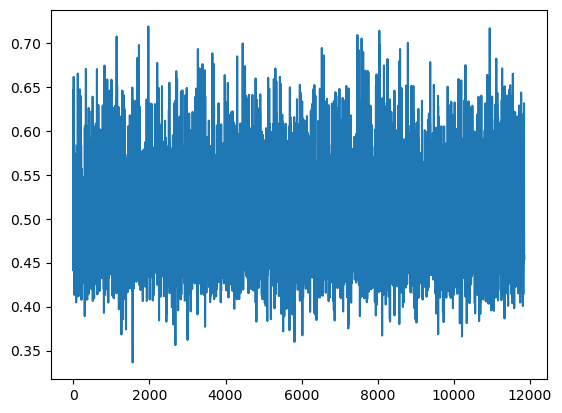

0.336495110035793 0.7185801443335934


In [300]:
import matplotlib.pyplot as plt

plt.plot(y_pred_final)
plt.show()
print(np.min(y_pred_final), np.max(y_pred_final))

In [301]:
output_data = {'Id': Id, 'Popularity': y_pred_final}
output_dataframe = pd.DataFrame(output_data)
print(output_dataframe)

output_dataframe.to_csv("./datasets/y_pred.csv", index=None)

          Id  Popularity
0      27643    0.449739
1      27644    0.498256
2      27645    0.440992
3      27646    0.466863
4      27647    0.478450
...      ...         ...
11842  39485    0.631300
11843  39486    0.504553
11844  39487    0.478040
11845  39488    0.453085
11846  39489    0.457741

[11847 rows x 2 columns]


## Report

### Student ID and Name

- 109062135 陳家輝
- 109062117 吳展維
- 109062335 王懷鴻
- 109062108 陳寬宸

### Featrue Engineering

- Feature Selection

    我們嘗試了很多的feature，例如字數，圖片，正向和負向字詞的統計，或是將feature轉換成有意義的數字，像是author和topic score，或是計算一些feature的比例，像是單獨出現字詞的比例。隨後使用Ridge去找出各個feature的重要程度，並選擇性的刪除一些比較不重要的feature。

- Info Word
    - Title

    - Data Channel

    - Author 
    
    - Related Topics

    - Time (Conver`HH:MM` to `HH * 60 + MM`, then conver to `morning`, `noon`, `afternoon`, `night`)
   
    - Weekday or Weekend
   
    - Word count (`wordshort`, `wordmedium`, `wordlong`)
   
    - Video + Image count (`nomedia`, `fewmedia`, `manymedia`)
   
    - Link + Strong Header Count (`nomedia`, `fewmedia`, `manymedia`)
   
    - Number Count (`fewstats`, `somestats`, `manystats`, `lostats`)
   
    - Positive and Negative Words
- Info Stats

    - Time
    
    - Weekend
    
    - Word count
    
    - Scipt count
    
    - Video + Image count
    
    - Link and Strong count

    - Number count
    
    - Positive and Negative count

    - `?` and `!` count

    - Title length

    - Average word length and Unique word rate

- Content

    在文章內容feature的選擇上，我們將內文中每個段落的第一句和最後一句話選取出來。因為文章的架構一般是起承轉合，一個段落的第一句話起頭，最後一句話總和，恰巧包含了該段落最重要的資訊。

### Model Selection and Traning

- SGDClassifier
    
    直接使用Template裡面的model作為初期的嘗試，發現搭配HashingVectorizer的效果還不錯，後來在Info word model的選用上，表現較其他好或較穩定，所以就被徵召了。

- XGBClassifier

    作為現今主流的classifier的三巨頭之一，甚至可以說為老大的他，在前期的表現卻差強人意，可能是我們選的feature它不喜歡QQ。但後來將眾多feature結合起來餵給它後，在Voting內表現良好。

- LGBMClassifier

    同為現今主流的classifier的三巨頭之一，其表現在Info stats feature上力壓SGD和XGB，並且也比RandomForest穩定。

- RandomForestClassifier

    讓我們又愛又恨的RandomForest，愛是愛他什麼feature train出來score都蠻不錯的，恨就恨在那個score有的時候是假的，雖然已經將tree的數量增加到五百，但有的時候仍然會有偏頗，可最後我們仍然選用其作為Content model。

- GradientBoostingClassifier

    雖然在Info stats feature上單打獨鬥幹不過LGBMClassifier，但是在最終嘗試裡，結合XGBMClassifier在Voting內表現良好。

- VotingClassifier

    可以結合多個model對眾多feature進行訓練，每個內部模型的表現不一，但經過Voting之後可以呈現較好的表現，正所謂人多力量大。

- Voting Ratio

    參照RandomForest的作法，我們將不同feature用不同的model進行訓練，也就是使用Info word, Info num和Content model三者的predict做乘上比例並相加作為最終的預測，透過Ratio分配選擇，選出一個在train和valid表現上都較好的比例作為Final predict的分配。

### Final Approach

    在最後的嘗試裡，我們發現`feature_selection_part2`在單個模型上有比較好的表現，經過多個模型的測試，我們選用VotingClassifier包含XGBClassifier和GradientBoosting Classifier作為最終的模型

### Conclusion
    
    將多個model結合起來最後用比例分配的作法在valid的表現上可以比個別model都要來得好，但在public上卻沒有想像的好，我們猜測可能是因為feature之間並不是獨立的。

    之後的Cup要早點開始，因為每天繳交的次數有限，到後面的時候擔心次數用完，有一些方向不敢就這麼丟上去看是否正確，只能透過不是很準的valid去相信它在test上也可以表現的很好，而且到後面training的時間也會越久，需要更多的時間去嘗試不同的方向。

| train score | valid score | public score | Method              |
|:--------- | --------- |:------------ | ------------------- |
| 0.701   | 0.561   | 0.544      | Feature Hashing + SGDClassifier |
| 0.857 | 0.548 |        | Info word + Feature Hashing + XGBClassifier <br> Info num + GradientBoostingClassifier <br> Content + TFIDF +RandomForestClassifier <br> Proportion: 0, 0.4, 0.6|
| 0.769 |	0.567 |        | Info word + Feature Hashing + SGDClassifier <br>Info num + GradientBoostingClassifier <br>Content + TFIDF +RandomForestClassifier <br> Proportion: 0.45, 0.1925, 0.3575 |
| 0.888   | 0.576   | 0.550      |  Info word + Feature Hashing + RandomForestClassifier<br>Info num + RandomForestClassifier<br>Content + TFIDF +RandomForestClassifier<br>Proportion: 0.4, 0.27, 0.33 |
| 0.857 | 0.548 |        | TFIDF + LogisticRegression |
| 0.627 | 0.553 |        | TFIDF + SGDClassifier      |
|0.911  |0.546  |        | TFIDF + XGBClassifier      |
|0.713  | 0.558 |        | TFIDF + RndomForestClassifier                           |
| 0.817   | 0.569   | 0.552      | TF-IDF + xgboost + GradientBoostingClassifier |
| 0.591   | 0.584   | 0.562      | Feature_selection_part2 + XGBClassifier |
| 0.788   | 0.593   | 0.570      | (Info word + SGDCalssifier) & (Info stats + LGBMClassifier) & (Content + RandomForestClassifier)
| 0.626   | 0.595   | 0.565      | Feature_selection_part2 + VotingClassifier|